# Panel dashboard

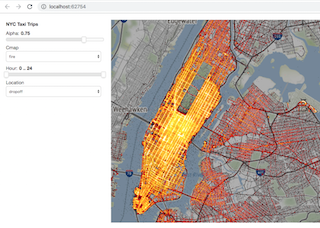

The [NYC Taxi trips](https://anaconda.org/jbednar/nyc_taxi/notebook) dataset is a well-studied data science example. Here we show how to build a simple dashboard for exploring 10 million taxi trips in a Jupyter notebook using [Datashader](http://datashader.org), then deploying it as a standalone dashboard using [Panel](http://panel.pyviz.org).

Running the dashboard requires having a live Python process running (not just a static webpage or anaconda.org notebook viewer).  Before you run the notebook or server, you'll need to set up a [conda](http://conda.pydata.org/miniconda.html) environment and run `conda install -c pyviz datashader panel holoviews`, and you'll need to [get the data file](https://anaconda.org/jbednar/nyc_taxi/notebook).

In [ ]:
import holoviews as hv
import hvplot.dask # noqa
import param
import dask.dataframe as dd
import panel as pn

from holoviews.operation.datashader import rasterize, dynspread
from holoviews.element.tiles import EsriStreet

hv.extension('bokeh', logo=False)

In [ ]:
usecols = ['dropoff_x', 'dropoff_y', 'pickup_x', 'pickup_y', 'dropoff_hour', 'pickup_hour', 'passenger_count']
df = dd.read_parquet('data/nyc_taxi_wide.parq', engine='fastparquet')[usecols].persist()
opts = dict(width=1000, height=600, xaxis=None, yaxis=None, bgcolor='black', show_grid=False)
cmaps = ['fire', 'bgy', 'bgyw', 'bmy', 'gray', 'kbc']

df.head()

In [ ]:
class NYCTaxiExplorer(pn.viewable.Viewer):
    alpha      = param.Magnitude(default=0.75, doc="Alpha value for the map opacity")
    cmap       = param.Selector(objects=cmaps)
    hour       = param.Range(default=(0, 24), bounds=(0, 24))
    location   = param.Selector(objects=['dropoff', 'pickup'])

    @param.depends('location', 'hour')
    def points(self):
        points = hv.Points(df, kdims=[self.location+'_x', self.location+'_y'], vdims=['dropoff_hour'])
        if self.hour != (0, 24):
            points = points.select(dropoff_hour=self.hour)
        return points

    def __panel__(self, **kwargs):
        points = hv.DynamicMap(self.points)
        tiles = EsriStreet().apply.opts(alpha=self.param.alpha, **opts)
        agg = rasterize(points, width=600, height=400).opts(cnorm='eq_hist', nodata=0)
        return tiles * dynspread(agg).apply.opts(cmap=self.param.cmap)
        
taxi = NYCTaxiExplorer(name="NYC Taxi Trips")
pn.Row(taxi.param, taxi).servable()

As you can see, the resulting object is rendered in the notebook (above), and it's usable as long as you have Python running on this code. You can also launch this app as a standalone server outside of the notebook, because we've marked the relevant object `.servable()`.  That declaration means that if someone later runs this notebook as a server process (using `panel serve --show dashboard.ipynb`), your browser will open a separate window with the serveable object ready to explore or share, just like the screenshot at the top of this notebook.

In [ ]:
# ! panel serve --show --port 5009 dashboard.ipynb